In [13]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class HandwrittenDigitsDataset(Dataset):
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.transform = transform
        self.image_files = [os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith('.png')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        label_path = img_path.replace('.png', '.txt')
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                label_data = line.strip().split('\t')
                digit_label = int(label_data[0])
                bbox_coords = [float(coord) for coord in label_data[1:]]
                labels.append([digit_label] + bbox_coords)
        
        if self.transform:
            image = self.transform(image)
        
        labels = np.array(labels, dtype=np.float32)
        return image, labels

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
path = "D:\Casper\OTHER\Data\\aML\hw6\HW6_train\\5\\"


train_dataset = HandwrittenDigitsDataset(path, transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: x)

# test_dataset = HandwrittenDigitsDataset('HW6_test', transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: x)


In [23]:
import os

def max_lines_in_txt(images_folder):
    max_lines = 0
    txt_files = [os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith('.txt')]
    
    for txt_file in txt_files:
        with open(txt_file, 'r') as f:
            num_lines = sum(1 for line in f)
            if num_lines > max_lines:
                max_lines = num_lines
    
    print(f"The maximum number of lines in a single txt file is: {max_lines}")

max_lines_in_txt(path)


Label:
 [[0.        0.515625  0.40625   0.21875   0.21875  ]
 [3.        0.015625  0.7734375 0.21875   0.21875  ]
 [4.        0.65625   0.7109375 0.21875   0.21875  ]]


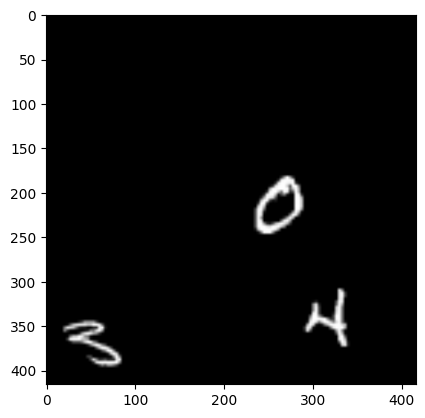

In [22]:
def display_image_and_tensor(dataset, index):
    image, label = dataset[index]  # Get the first image and its label
    print("Label:\n", label)
    image_np = image.squeeze().numpy()  
    plt.imshow(image_np, cmap='gray')
    plt.show()

display_image_and_tensor(train_dataset, 1)

In [19]:
import torch.nn as nn

class YOLO(nn.Module):
    def __init__(self, num_classes, num_boxes):
        super(YOLO, self).__init__()
        self.num_classes = num_classes
        self.num_boxes = num_boxes
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        
        self.fc1 = nn.Linear(512 * 13 * 13, 4096)
        self.fc2 = nn.Linear(4096, 13 * 13 * (num_classes + 5 * num_boxes))
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 13, 13, self.num_classes + 5 * self.num_boxes)
        return x

model = YOLO(num_classes=10, num_boxes=2)


In [4]:
class YoloLoss(nn.Module):
    def __init__(self, S, B, C):
        super(YoloLoss, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.mse = nn.MSELoss(reduction='sum')
    
    def forward(self, predictions, target):
        N = predictions.size(0)
        predictions = predictions.view(N, self.S, self.S, self.C + self.B * 5)
        
        coord_mask = target[..., 4] > 0
        noobj_mask = target[..., 4] == 0
        
        coord_predictions = predictions[coord_mask].view(-1, self.C + self.B * 5)
        noobj_predictions = predictions[noobj_mask].view(-1, self.C + self.B * 5)
        
        coord_target = target[coord_mask].view(-1, self.C + self.B * 5)
        noobj_target = target[noobj_mask].view(-1, self.C + self.B * 5)
        
        coord_loss = self.mse(coord_predictions, coord_target)
        noobj_loss = self.mse(noobj_predictions, noobj_target)
        
        return coord_loss + noobj_loss

criterion = YoloLoss(S=13, B=2, C=10)


In [5]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        targets = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader)}')


ValueError: too many values to unpack (expected 2)